# 🏥 Medical Disease Image Generation using Conditional DCGAN

## 🎯 Project Objective
Generate **synthetic brain MRI images** for different dementia severity stages using **Conditional Deep Convolutional GAN**.

**Use Case Example:**
- Input: Noise vector + Stage label (e.g., "Mild Dementia")
- Output: Generated brain MRI image with that severity level

## 🧠 Conditional DCGAN for Medical Image Generation
**Concept**: Generate realistic medical images conditioned on disease severity labels
- Input: Random noise (z) + Disease stage label (0-3)
- Output: Synthetic brain MRI image at specified stage
- Uses: Data augmentation, rare class balancing, research

**Why Conditional DCGAN?**
- ✅ Controlled generation based on disease stage
- ✅ Balanced data augmentation for all classes
- ✅ No need for paired training data
- ✅ Proven architecture for medical imaging

## 📊 Dataset (Dementia - OASIS)
**OASIS**: Brain MRI - Dementia progression (4 severity stages)
- Stage 0 = Non-Dementia
- Stage 1 = Very Mild Dementia
- Stage 2 = Mild Dementia
- Stage 3 = Moderate Dementia

**Dataset structure:**
```
dataset/
├── stage0/
│   ├── img001.png
│   └── ...
├── stage1/
│   └── ...
├── stage2/
│   └── ...
└── stage3/
    └── ...
```

## 🤖 Conditional DCGAN Architecture
- **Generator**: ConvTranspose layers with BatchNorm
  - Input: Noise (100-dim) + Label embedding (4-dim)
  - Output: 128x128x1 grayscale image
- **Discriminator**: Conv layers with label conditioning
  - Input: Image + Label embedding
  - Output: Real/Fake probability
- **Loss**: Binary Cross Entropy (Adversarial GAN loss)

## 🔄 Training Pipeline
```
Step 1: Load balanced dataset (all 4 stages) ✓
Step 2: Define Conditional DCGAN architecture ✓
Step 3: Train with adversarial loss + FID score ✓
Step 4: Generate samples for each class
Step 5: Save model & upload to HuggingFace
```

## 📈 Evaluation Metrics
- **Generator Loss**: Measures ability to fool discriminator
- **Discriminator Loss**: Measures real/fake classification accuracy

## 💾 Output
- Conditional DCGAN model (Generator, Discriminator)
- Generated samples (1 per class)
- Training history with FID scores
- HuggingFace model upload

---
**Current Focus**: Conditional image generation for disease stage synthesis

In [1]:
!pip install -q torch torchvision pillow matplotlib numpy pandas scipy

import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
import time
import json
from collections import defaultdict, Counter
from scipy import linalg
from torch.cuda.amp import autocast, GradScaler

# ================== DEVICE SETUP ==================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")

# ================== AMP SETUP ==================
use_amp = torch.cuda.is_available()  # Enable AMP only if CUDA is available
scaler_G = GradScaler() if use_amp else None
scaler_D = GradScaler() if use_amp else None
print(f"✓ Mixed Precision (AMP) enabled: {use_amp}")

# ================== CONFIGURATION ==================
print("\n" + "="*60)
print("CONDITIONAL DCGAN CONFIGURATION")
print("="*60)

# Dataset configuration
STAGE_NAMES = {
    0: "Non-Dementia",
    1: "Very Mild Dementia",
    2: "Mild Dementia",
    3: "Moderate Dementia"
}
NUM_CLASSES = 4

# Model configuration 
img_size = 128
NUM_WORKERS = 2
z_dim = 100     # Latent noise dimension
batch_size = 16
num_epochs = 10

# Optimizer configuration
lr_G = 2e-4
lr_D = 2e-5
beta1 = 0.5
beta2 = 0.999

# Training configuration
seed = 42
save_checkpoint_every = 2

# Set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print("✓ Configuration loaded:")
print(f"  - Image size: {img_size}x{img_size}")
print(f"  - Batch size: {batch_size}")
print(f"  - Classes: {NUM_CLASSES} dementia stages")
print(f"  - Model: Conditional DCGAN")
print(f"  - Epochs: {num_epochs}")
print(f"  - Latent dim: {z_dim}")
print(f"  - Device: {device}")
print(f"  - Mixed Precision: {use_amp}")

🚀 Using device: cuda
✓ Mixed Precision (AMP) enabled: True

CONDITIONAL DCGAN CONFIGURATION
✓ Configuration loaded:
  - Image size: 128x128
  - Batch size: 16
  - Classes: 4 dementia stages
  - Model: Conditional DCGAN
  - Epochs: 10
  - Latent dim: 100
  - Device: cuda
  - Mixed Precision: True


/tmp/ipykernel_55/2819681820.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler() if use_amp else None
/tmp/ipykernel_55/2819681820.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler() if use_amp else None


In [2]:
# =========================================================
# BALANCED MULTI-CLASS MRI DATASET (OASIS - Kaggle)
# FIXED FOLDER NAMES
# =========================================================

import os
from pathlib import Path
from collections import Counter

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T

# =========================================================
# CONFIG
# =========================================================
DATASET_ROOT = "/kaggle/input/imagesoasis/Data"

# 🔥 FIXED: EXACT FOLDER NAMES FROM DATASET
CLASS_FOLDERS = {
    0: "Non Demented",
    1: "Very mild dementia",
    2: "Mild dementia",
    3: "Moderate dementia"
}

STAGE_NAMES = CLASS_FOLDERS
NUM_CLASSES = len(CLASS_FOLDERS)

print("\n" + "=" * 60)
print("STEP 1: Balanced Multi-Class Dataset Loading (OASIS)")
print("=" * 60)

# =========================================================
# DATASET CLASS
# =========================================================
class MRIDataset(Dataset):
    """
    Multi-class MRI dataset with balanced sampling support.
    Suitable for Conditional DCGAN / cGAN.
    """

    def __init__(self, root_dir, img_size=128):
        self.root_dir = Path(root_dir)
        self.img_size = img_size

        self.data = []
        self.class_counts = Counter()

        print("\n🔍 Scanning dataset folders...")

        # List existing folders once (case insensitive safety)
        existing_folders = {p.name.lower(): p for p in self.root_dir.iterdir() if p.is_dir()}

        for label, folder_name in CLASS_FOLDERS.items():
            key = folder_name.lower()

            if key not in existing_folders:
                raise FileNotFoundError(
                    f"Folder '{folder_name}' not found.\n"
                    f"Available folders: {list(existing_folders.keys())}"
                )

            class_dir = existing_folders[key]
            img_paths = list(class_dir.glob("*"))

            for img_path in img_paths:
                self.data.append((str(img_path), label))
                self.class_counts[label] += 1

            print(f"  ✓ {folder_name}: {len(img_paths)} images")

        print("\n📊 Dataset Class Distribution:")
        for label in range(NUM_CLASSES):
            print(f"  Class {label} ({STAGE_NAMES[label]}): {self.class_counts[label]} images")

        print(f"\n  Total images: {len(self.data)}")

        # DCGAN-style transform
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])  # [-1, 1]
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        img = Image.open(img_path).convert("L")
        img = self.transform(img)
        return img, label

    # =====================================================
    # BALANCED SAMPLER
    # =====================================================
    def get_balanced_sampler(self):
        class_weights = {
            cls: 1.0 / count
            for cls, count in self.class_counts.items()
        }

        sample_weights = [
            class_weights[label]
            for _, label in self.data
        ]

        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )

        print("\n⚖️ Balanced Sampler Created")
        for cls, w in class_weights.items():
            print(f"  Class {cls} ({STAGE_NAMES[cls]}): weight={w:.6f}")

        return sampler


# =========================================================
# CREATE DATASET & DATALOADER
# =========================================================
dataset = MRIDataset(
    root_dir=DATASET_ROOT,
    img_size=img_size
)

balanced_sampler = dataset.get_balanced_sampler()

train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=balanced_sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

print("\n" + "=" * 60)
print("DataLoader Summary")
print("=" * 60)
print(f"  Total images      : {len(dataset)}")
print(f"  Num classes       : {NUM_CLASSES}")
print(f"  Batch size        : {batch_size}")
print(f"  Batches / epoch   : {len(train_loader)}")
print(f"  Sampling strategy : Balanced (WeightedRandomSampler)")
print(f"  Image range       : [-1, 1]")
print("\n✅ Dataset READY for Conditional DCGAN training!\n")



STEP 1: Balanced Multi-Class Dataset Loading (OASIS)

🔍 Scanning dataset folders...
  ✓ Non Demented: 67222 images
  ✓ Very mild dementia: 13725 images
  ✓ Mild dementia: 5002 images
  ✓ Moderate dementia: 488 images

📊 Dataset Class Distribution:
  Class 0 (Non Demented): 67222 images
  Class 1 (Very mild dementia): 13725 images
  Class 2 (Mild dementia): 5002 images
  Class 3 (Moderate dementia): 488 images

  Total images: 86437

⚖️ Balanced Sampler Created
  Class 0 (Non Demented): weight=0.000015
  Class 1 (Very mild dementia): weight=0.000073
  Class 2 (Mild dementia): weight=0.000200
  Class 3 (Moderate dementia): weight=0.002049

DataLoader Summary
  Total images      : 86437
  Num classes       : 4
  Batch size        : 16
  Batches / epoch   : 5402
  Sampling strategy : Balanced (WeightedRandomSampler)
  Image range       : [-1, 1]

✅ Dataset READY for Conditional DCGAN training!



In [3]:
print("\n" + "="*60)
print("STEP 2: Conditional DCGAN Architecture (FIXED & STABLE)")
print("="*60)

import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm

# ============================================================
# GENERATOR: Conditional DCGAN (UNCHANGED CORE)
# ============================================================

class Generator(nn.Module):
    """
    Conditional DCGAN Generator.

    - Input: Noise z + label embedding
    - Architecture: ConvTranspose + BatchNorm + ReLU
    - Output: 128x128x1 via Tanh
    """
    def __init__(self, z_dim=100, num_classes=4, img_channels=1):
        super().__init__()

        # Label embedding (small, concatenated to z)
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim + num_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, label_emb], dim=1)
        return self.net(x)


# ============================================================
# DISCRIMINATOR: Projection Discriminator (Weakened Conditioning)
# ============================================================

class Discriminator(nn.Module):
    """
    Projection Discriminator.

    - Conditioning via projection: <h, embed(label)>
    - No spatial label map (reduces pixel locking)
    - Logits output (use BCEWithLogitsLoss)
    - SpectralNorm on Conv2d for stability
    """
    def __init__(self, num_classes=4, img_channels=1):
        super().__init__()

        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(img_channels, 64, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(256, 512, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.linear = nn.Linear(512 * 8 * 8, 1)
        self.embed = nn.Embedding(num_classes, 512 * 8 * 8)

    def forward(self, x, labels):
        h = self.conv(x)
        h = h.view(h.size(0), -1)

        out = self.linear(h)
        proj = torch.sum(self.embed(labels) * h, dim=1, keepdim=True)

        return out + proj


# ============================================================
# Weight Initialization (DCGAN Standard)
# ============================================================

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# ============================================================
# Initialize Models
# ============================================================

G = Generator(
    z_dim=z_dim,
    num_classes=NUM_CLASSES,
    img_channels=1
).to(device)

D = Discriminator(
    num_classes=NUM_CLASSES,
    img_channels=1
).to(device)

G.apply(init_weights)
D.apply(init_weights)

print(f"✓ Generator parameters:     {sum(p.numel() for p in G.parameters()):,}")
print(f"✓ Discriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

print("\n✓ Conditional DCGAN architecture READY (UPDATED)")
print("  - Generator: ConvTranspose + BatchNorm + ReLU")
print("  - Discriminator: Conv + LeakyReLU + SpectralNorm")
print("  - Conditioning (D): Projection (label embedding · features)")
print("  - Output: Logits (use BCEWithLogitsLoss)")
print(f"  - Image size: {img_size}x{img_size}")
print(f"  - Latent dim: {z_dim}")


STEP 2: Conditional DCGAN Architecture (FIXED & STABLE)
✓ Generator parameters:     3,639,760
✓ Discriminator parameters: 2,918,337

✓ Conditional DCGAN architecture READY (UPDATED)
  - Generator: ConvTranspose + BatchNorm + ReLU
  - Discriminator: Conv + LeakyReLU + SpectralNorm
  - Conditioning (D): Projection (label embedding · features)
  - Output: Logits (use BCEWithLogitsLoss)
  - Image size: 128x128
  - Latent dim: 100


In [4]:
print("\n" + "="*60)
print("STEP 3: Conditional DCGAN Training (Visual Evaluation Only) + AMP")
print("="*60)

# ============================================================
# Loss Function & Optimizers (FIXED)
# ============================================================

# ❌ BCELoss (unsafe for AMP)
# criterion = nn.BCELoss()

# ✅ AMP-safe
criterion = nn.BCEWithLogitsLoss()

opt_G = optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
opt_D = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))

# AMP utilities (FIXED API)
from torch.amp import autocast, GradScaler
scaler_G = GradScaler(enabled=use_amp)
scaler_D = GradScaler(enabled=use_amp)

print(f"✓ Loss function: BCEWithLogitsLoss (AMP-safe)")
print(f"✓ Optimizer G: Adam (lr={lr_G})")
print(f"✓ Optimizer D: Adam (lr={lr_D})")
print(f"✓ Mixed Precision (AMP): {use_amp}")
print("\nModel evaluation is conducted qualitatively through visual inspection.")

# ============================================================
# Training History (no FID)
# ============================================================

history = {
    'epoch': [],
    'loss_G': [],
    'loss_D': [],
    'loss_D_real': [],
    'loss_D_fake': [],
    'epoch_time': []
}

# ============================================================
# Training Loop (AMP) — Visual checkpoints only
# ============================================================

print(f"\n{'='*60}")
print(f"Starting Conditional DCGAN Training: {num_epochs} epochs")
print(f"Classes: {NUM_CLASSES} (balanced sampling)")
print(f"Train batches: {len(train_loader)}")
print(f"Mixed Precision: {use_amp}")
print(f"{'='*60}\n")

fixed_z = torch.randn(NUM_CLASSES, z_dim, 1, 1, device=device)
fixed_labels = torch.arange(NUM_CLASSES, device=device)

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    G.train(); D.train()
    
    epoch_loss_G = 0.0
    epoch_loss_D = 0.0
    epoch_loss_D_real = 0.0
    epoch_loss_D_fake = 0.0
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size_actual = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        real_targets = torch.ones(batch_size_actual, 1, device=device)
        fake_targets = torch.zeros(batch_size_actual, 1, device=device)
        
        # =====================================================
        # Train Discriminator
        # =====================================================
        opt_D.zero_grad(set_to_none=True)
        
        z = torch.randn(batch_size_actual, z_dim, 1, 1, device=device)
        
        with autocast("cuda", enabled=use_amp):
            fake_imgs = G(z, labels)

            real_logits = D(real_imgs, labels)
            fake_logits = D(fake_imgs.detach(), labels)

            loss_D_real = criterion(real_logits, real_targets)
            loss_D_fake = criterion(fake_logits, fake_targets)
            loss_D = loss_D_real + loss_D_fake
        
        scaler_D.scale(loss_D).backward()
        scaler_D.step(opt_D)
        scaler_D.update()
        
        # =====================================================
        # Train Generator
        # =====================================================
        opt_G.zero_grad(set_to_none=True)
        
        with autocast("cuda", enabled=use_amp):
            fake_logits = D(fake_imgs, labels)
            loss_G = criterion(fake_logits, real_targets)
        
        scaler_G.scale(loss_G).backward()
        scaler_G.step(opt_G)
        scaler_G.update()
        
        # Accumulate
        epoch_loss_G += loss_G.item()
        epoch_loss_D += loss_D.item()
        epoch_loss_D_real += loss_D_real.item()
        epoch_loss_D_fake += loss_D_fake.item()
        
        if (i + 1) % 10 == 0 or i == 0:
            print(
                f"Epoch [{epoch+1:3d}/{num_epochs}] "
                f"Batch [{i+1:3d}/{len(train_loader):3d}] | "
                f"G: {loss_G.item():.4f} | "
                f"D: {loss_D.item():.4f} | "
                f"D_real: {loss_D_real.item():.4f} | "
                f"D_fake: {loss_D_fake.item():.4f}"
            )
    
    # =====================================================
    # Epoch statistics
    # =====================================================
    num_batches = len(train_loader)
    epoch_loss_G /= num_batches
    epoch_loss_D /= num_batches
    epoch_loss_D_real /= num_batches
    epoch_loss_D_fake /= num_batches
    epoch_time = time.time() - epoch_start
    
    history['epoch'].append(epoch + 1)
    history['loss_G'].append(epoch_loss_G)
    history['loss_D'].append(epoch_loss_D)
    history['loss_D_real'].append(epoch_loss_D_real)
    history['loss_D_fake'].append(epoch_loss_D_fake)
    history['epoch_time'].append(epoch_time)
    
    if (epoch + 1) % 1 == 0 or epoch == 0:
        print(f"\n✓ Epoch [{epoch+1}/{num_epochs}] Summary:")
        print(f"  Generator Loss:     {epoch_loss_G:.4f}")
        print(f"  Discriminator Loss: {epoch_loss_D:.4f}")
        print(f"  D Loss (Real):      {epoch_loss_D_real:.4f}")
        print(f"  D Loss (Fake):      {epoch_loss_D_fake:.4f}")
        print(f"  Time:               {epoch_time:.1f}s\n")
    
    # =====================================================
    # Visual checkpoint
    # =====================================================
    if (epoch + 1) % 3 == 0 or epoch == num_epochs - 1:
        G.eval()
        with torch.no_grad(), autocast("cuda", enabled=use_amp):
            samples = G(fixed_z, fixed_labels)
        
        fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(12, 3))
        for j in range(NUM_CLASSES):
            img = (samples[j].cpu().squeeze() + 1) / 2
            axes[j].imshow(img, cmap='gray')
            axes[j].set_title(f"Stage {j}")
            axes[j].axis('off')
        plt.tight_layout()
        plt.savefig(f'generated_epoch_{epoch+1}.png', dpi=100)
        plt.close()
        G.train()
    
    # =====================================================
    # Checkpoint
    # =====================================================
    if (epoch + 1) % save_checkpoint_every == 0:
        os.makedirs('./checkpoints', exist_ok=True)
        torch.save({
            'epoch': epoch + 1,
            'generator': G.state_dict(),
            'discriminator': D.state_dict(),
            'opt_G': opt_G.state_dict(),
            'opt_D': opt_D.state_dict(),
            'scaler_G': scaler_G.state_dict(),
            'scaler_D': scaler_D.state_dict(),
        }, f'./checkpoints/cgan_epoch_{epoch+1}.pth')
        print(f"  ✓ Checkpoint saved: epoch {epoch+1}\n")

print(f"\n{'='*60}")
print("✅ Training Complete!")
print(f"{'='*60}")
print(f"Final Generator Loss:     {history['loss_G'][-1]:.4f}")
print(f"Final Discriminator Loss: {history['loss_D'][-1]:.4f}")
print(f"Total training time:      {sum(history['epoch_time']):.1f}s")
print(f"Average time per epoch:   {np.mean(history['epoch_time']):.1f}s")
print("Model evaluation is conducted qualitatively through visual inspection.")

# ============================================================
# Final Fixed Samples
# ============================================================

print("\nSaving final fixed samples per class...")
G.eval()
with torch.no_grad(), autocast("cuda", enabled=use_amp):
    final_z = torch.randn(NUM_CLASSES, z_dim, 1, 1, device=device)
    final_labels = torch.arange(NUM_CLASSES, device=device)
    final_samples = G(final_z, final_labels)

for i in range(NUM_CLASSES):
    img = (final_samples[i].cpu().squeeze() + 1) / 2
    img = torch.clamp(img, 0, 1)
    img_np = (img.numpy() * 255).astype('uint8')
    Image.fromarray(img_np, mode='L').save(f'final_stage_{i}.png')
    print(f"  ✓ final_stage_{i}.png saved")



STEP 3: Conditional DCGAN Training (Visual Evaluation Only) + AMP
✓ Loss function: BCEWithLogitsLoss (AMP-safe)
✓ Optimizer G: Adam (lr=0.0002)
✓ Optimizer D: Adam (lr=2e-05)
✓ Mixed Precision (AMP): True

Model evaluation is conducted qualitatively through visual inspection.

Starting Conditional DCGAN Training: 10 epochs
Classes: 4 (balanced sampling)
Train batches: 5402
Mixed Precision: True

Epoch [  1/10] Batch [  1/5402] | G: 0.9866 | D: 7.3559 | D_real: 3.6990 | D_fake: 3.6569
Epoch [  1/10] Batch [ 10/5402] | G: 2.5919 | D: 0.7031 | D_real: 0.3426 | D_fake: 0.3605
Epoch [  1/10] Batch [ 20/5402] | G: 3.0598 | D: 0.6942 | D_real: 0.4440 | D_fake: 0.2502
Epoch [  1/10] Batch [ 30/5402] | G: 5.9323 | D: 1.4444 | D_real: 0.0032 | D_fake: 1.4412
Epoch [  1/10] Batch [ 40/5402] | G: 5.6099 | D: 0.2619 | D_real: 0.1310 | D_fake: 0.1309
Epoch [  1/10] Batch [ 50/5402] | G: 4.0682 | D: 4.7585 | D_real: 0.1696 | D_fake: 4.5889
Epoch [  1/10] Batch [ 60/5402] | G: 2.4377 | D: 2.6904 | D_

/tmp/ipykernel_55/1546560695.py:208: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img_np, mode='L').save(f'final_stage_{i}.png')



STEP 4: Generate Samples & Visualize Results

🎨 Generating 1 sample per dementia stage...


/tmp/ipykernel_55/2728325626.py:56: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img_np, mode="L").save(f"generated_class_{i}.png")


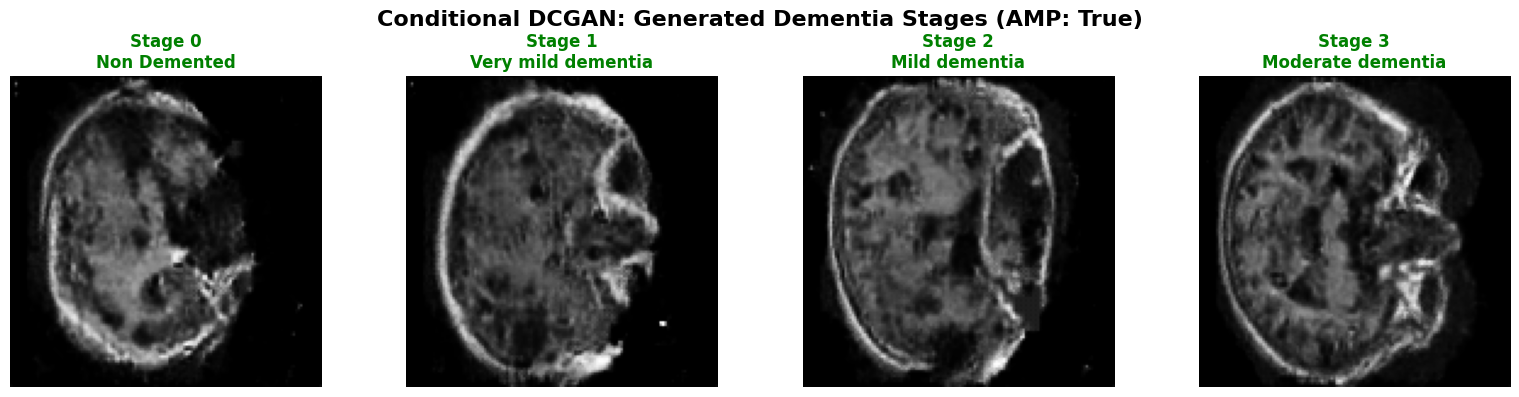


✓ Generated samples saved:
  - generated_class_0.png (Non Demented)
  - generated_class_1.png (Very mild dementia)
  - generated_class_2.png (Mild dementia)
  - generated_class_3.png (Moderate dementia)
  - generated_all_classes.png (combined)


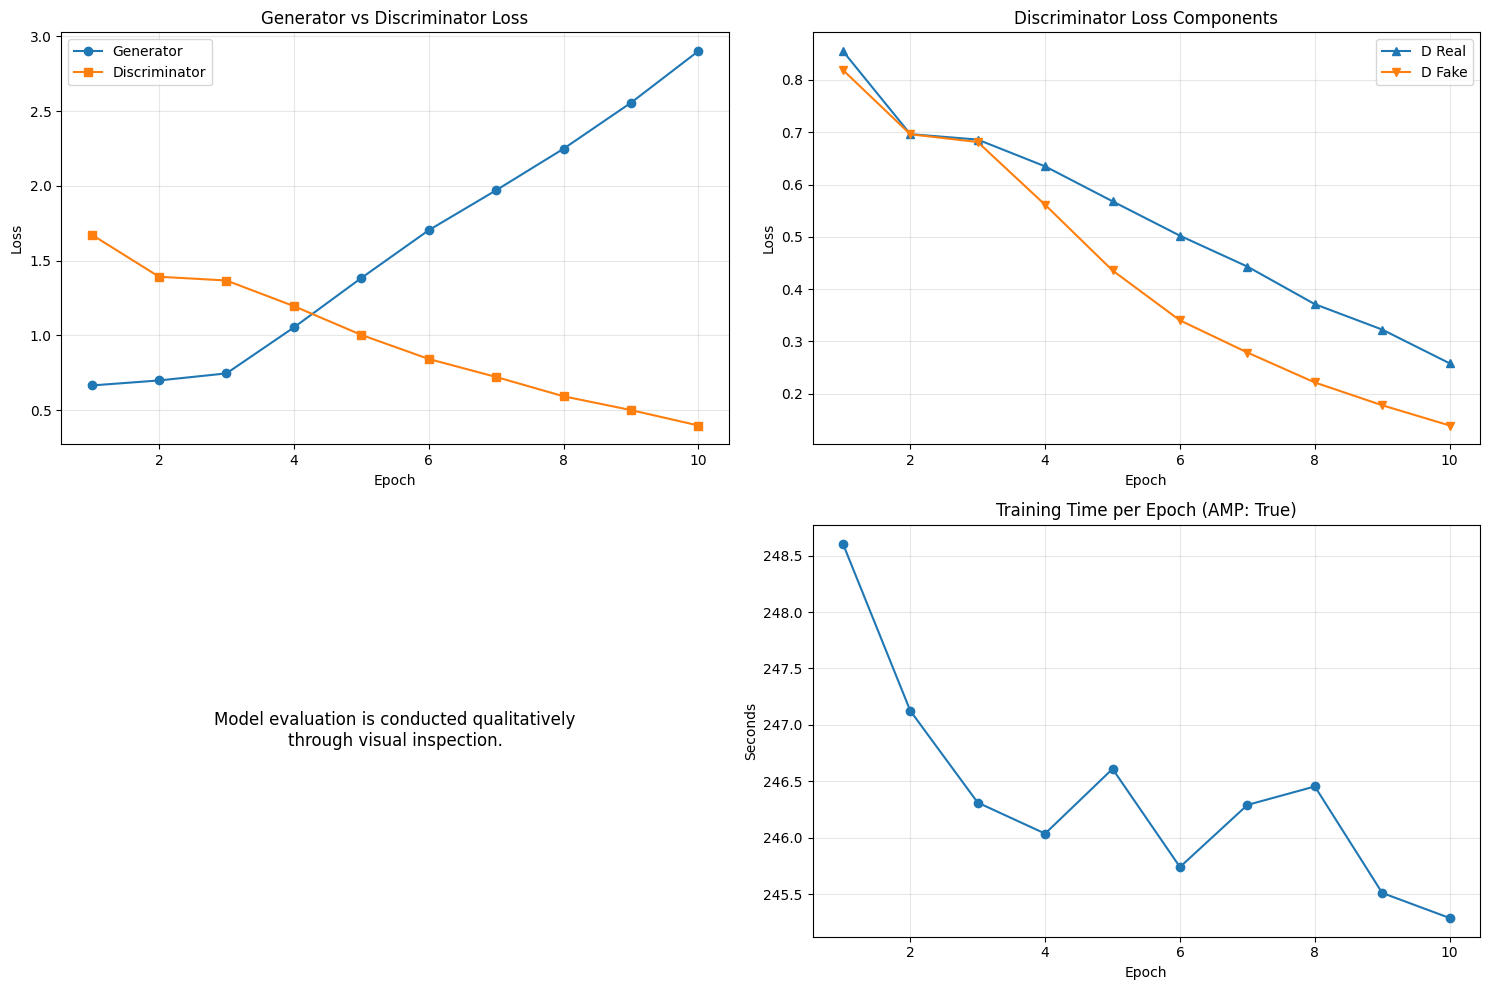


✓ Training history plotted
✓ Saved: training_history.png

Training Summary Statistics
Total epochs: 10
Batches per epoch: 5402
Total iterations: 54020
Average time per epoch: 246.4s
Total training time: 41.1 minutes
Mixed Precision: True

Final Loss Values:
  Generator Loss:     2.9015
  Discriminator Loss: 0.3976
  D Loss (Real):      0.2582
  D Loss (Fake):      0.1394

✓ Dataset: 86437 images across 4 balanced classes
✓ Model evaluation performed qualitatively


In [5]:
print("\n" + "="*60)
print("STEP 4: Generate Samples & Visualize Results")
print("="*60)

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.amp import autocast

# ============================================================
# Generate 1 Sample per Class (AMP-safe)
# ============================================================

G.eval()

print(f"\n🎨 Generating 1 sample per dementia stage...")

with torch.no_grad():

    # latent + label
    z_samples = torch.randn(NUM_CLASSES, z_dim, 1, 1, device=device)
    labels_samples = torch.arange(NUM_CLASSES, device=device)

    # AMP-safe autocast
    with autocast(
        device_type=device.type,
        enabled=use_amp
    ):
        generated_samples = G(z_samples, labels_samples)

    # ================= Visualization =================
    fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(16, 4))
    fig.suptitle(
        f"Conditional DCGAN: Generated Dementia Stages (AMP: {use_amp})",
        fontsize=16,
        fontweight='bold'
    )

    for i in range(NUM_CLASSES):
        img = generated_samples[i].cpu().squeeze()
        img = (img + 1) / 2.0
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(
            f"Stage {i}\n{STAGE_NAMES[i]}",
            fontsize=12,
            fontweight='bold',
            color='green'
        )
        axes[i].axis("off")

        # save per-class image
        img_np = (img.numpy() * 255).astype(np.uint8)
        Image.fromarray(img_np, mode="L").save(f"generated_class_{i}.png")

    plt.tight_layout()
    plt.savefig("generated_all_classes.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"\n✓ Generated samples saved:")
    for i in range(NUM_CLASSES):
        print(f"  - generated_class_{i}.png ({STAGE_NAMES[i]})")
    print(f"  - generated_all_classes.png (combined)")

# ============================================================
# Plot Training History (Losses)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history["epoch"], history["loss_G"], label="Generator", marker="o")
axes[0, 0].plot(history["epoch"], history["loss_D"], label="Discriminator", marker="s")
axes[0, 0].set_title("Generator vs Discriminator Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(history["epoch"], history["loss_D_real"], label="D Real", marker="^")
axes[0, 1].plot(history["epoch"], history["loss_D_fake"], label="D Fake", marker="v")
axes[0, 1].set_title("Discriminator Loss Components")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].axis("off")
axes[1, 0].text(
    0.5, 0.5,
    "Model evaluation is conducted qualitatively\nthrough visual inspection.",
    ha="center", va="center", fontsize=12
)

axes[1, 1].plot(history["epoch"], history["epoch_time"], marker="o")
axes[1, 1].set_title(f"Training Time per Epoch (AMP: {use_amp})")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Seconds")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("training_history.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Training history plotted")
print("✓ Saved: training_history.png")

# ============================================================
# Summary Statistics
# ============================================================

print("\n" + "="*60)
print("Training Summary Statistics")
print("="*60)

print(f"Total epochs: {num_epochs}")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Total iterations: {num_epochs * len(train_loader)}")
print(f"Average time per epoch: {np.mean(history['epoch_time']):.1f}s")
print(f"Total training time: {sum(history['epoch_time']) / 60:.1f} minutes")
print(f"Mixed Precision: {use_amp}")

print("\nFinal Loss Values:")
print(f"  Generator Loss:     {history['loss_G'][-1]:.4f}")
print(f"  Discriminator Loss: {history['loss_D'][-1]:.4f}")
print(f"  D Loss (Real):      {history['loss_D_real'][-1]:.4f}")
print(f"  D Loss (Fake):      {history['loss_D_fake'][-1]:.4f}")

print("\n✓ Dataset:", len(dataset), "images across", NUM_CLASSES, "balanced classes")
print("✓ Model evaluation performed qualitatively")


In [6]:
print("\n" + "="*60)
print("STEP 5: Save Model & Configuration (Generator Only)")
print("="*60)

# Create output directory
output_dir = './model_output'
os.makedirs(output_dir, exist_ok=True)

# ============================================================
# Save Generator Only (for HuggingFace inference)
# ============================================================

gen_export = {
    "model": G.state_dict(),
    "z_dim": z_dim,
    "num_classes": NUM_CLASSES,
    "img_size": img_size
}

torch.save(gen_export, f"{output_dir}/cDCGAN_generator.pth")
print(f"✓ Saved: {output_dir}/cDCGAN_generator.pth (generator only)")

# Optional: local training artifacts (not uploaded)
import pandas as pd
history_df = pd.DataFrame({
    'Epoch': history['epoch'],
    'Loss_G': history['loss_G'],
    'Loss_D': history['loss_D'],
    'Loss_D_Real': history['loss_D_real'],
    'Loss_D_Fake': history['loss_D_fake'],
    'Epoch_Time': history['epoch_time']
})

history_df.to_csv(f'{output_dir}/training_history.csv', index=False)
print(f"✓ Saved: {output_dir}/training_history.csv")

# Save architecture code matching the TRAINED model exactly
architecture_code = '''import torch
import torch.nn as nn

class Generator(nn.Module):
    """
    Conditional DCGAN Generator.
    
    - Input: Noise z + label embedding
    - Architecture: ConvTranspose + BatchNorm + ReLU
    - Output: 128x128x1 via Tanh
    """
    def __init__(self, z_dim=100, num_classes=4, img_channels=1):
        super().__init__()

        # Label embedding (small, concatenated to z)
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim + num_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_emb = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([z, label_emb], dim=1)
        return self.net(x)
'''

with open(f'{output_dir}/model_architecture.py', 'w') as f:
    f.write(architecture_code)
print(f"✓ Saved: {output_dir}/model_architecture.py (FIXED - matches trained model)")

# Save inference script that uses HuggingFace Hub
inference_code = '''"""
Inference script for Dementia CGAN - Downloads model from HuggingFace Hub
"""
import torch
from huggingface_hub import hf_hub_download
from model_architecture import Generator
from PIL import Image

# Configuration
HF_REPO_ID = "Arga23/dementia-cgan-mri"  # Your HuggingFace repo
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"🚀 Device: {device}")
print(f"📦 Downloading model from: {HF_REPO_ID}")

# Download generator checkpoint from HuggingFace
try:
    model_path = hf_hub_download(
        repo_id=HF_REPO_ID,
        filename="cDCGAN_generator.pth",
        cache_dir="./hf_cache"
    )
    print(f"✓ Model downloaded: {model_path}")
except Exception as e:
    print(f"❌ Download failed: {e}")
    print("💡 Make sure the model is uploaded to HuggingFace Hub")
    exit(1)

# Load checkpoint
checkpoint = torch.load(model_path, map_location=device)
print(f"✓ Checkpoint loaded")
print(f"  - z_dim: {checkpoint['z_dim']}")
print(f"  - num_classes: {checkpoint['num_classes']}")
print(f"  - img_size: {checkpoint['img_size']}")

# Initialize Generator with correct architecture
G = Generator(
    z_dim=checkpoint['z_dim'],
    num_classes=checkpoint['num_classes'],
    img_channels=1
).to(device)

G.load_state_dict(checkpoint['model'])
G.eval()
print("✓ Generator loaded successfully\\n")

# Stage names
STAGE_NAMES = {
    0: "Non-Dementia",
    1: "Very Mild Dementia",
    2: "Mild Dementia",
    3: "Moderate Dementia"
}

# Generate one sample per dementia stage
print("🎨 Generating samples for all dementia stages...\\n")

with torch.no_grad():
    for stage in range(checkpoint['num_classes']):
        # Random noise vector
        z = torch.randn(1, checkpoint['z_dim'], 1, 1).to(device)
        
        # Stage label
        label = torch.tensor([stage]).to(device)
        
        # Generate image
        img = G(z, label)
        
        # Post-process: [-1, 1] → [0, 1] → [0, 255]
        img = (img.squeeze().cpu() + 1) / 2
        img = torch.clamp(img, 0, 1)
        img_np = (img.numpy() * 255).astype('uint8')
        
        # Save image
        output_name = f'generated_stage_{stage}.png'
        Image.fromarray(img_np, mode='L').save(output_name)
        print(f"  ✓ {output_name} - {STAGE_NAMES[stage]}")

print("\\n✅ All samples generated successfully!")
print("\\n💡 Run this script anytime to generate new samples:")
print("   python inference.py")
'''

with open(f'{output_dir}/inference.py', 'w') as f:
    f.write(inference_code)
print(f"✓ Saved: {output_dir}/inference.py (uses HuggingFace Hub)")

# Copy key images
import shutil
for i in range(NUM_CLASSES):
    for name in [f'generated_class_{i}.png', f'final_stage_{i}.png']:
        if os.path.exists(name):
            shutil.copy(name, f'{output_dir}/{name}')
if os.path.exists('generated_all_classes.png'):
    shutil.copy('generated_all_classes.png', f'{output_dir}/generated_all_classes.png')
if os.path.exists('training_history.png'):
    shutil.copy('training_history.png', f'{output_dir}/training_history.png')

print(f"\n{'='*60}")
print(f"✅ All outputs saved to: {output_dir}/")
print(f"{'='*60}")
print(f"\nFiles:")
print(f"  ✓ cDCGAN_generator.pth        (generator for inference)")
print(f"  ✓ model_architecture.py       (FIXED - matches trained model)")
print(f"  ✓ inference.py                (uses HuggingFace Hub)")
print(f"  ✓ training_history.csv        (loss per epoch)")
print(f"  ✓ training_history.png        (loss curves)")
print(f"  ✓ generated_all_classes.png   (samples)")
for i in range(NUM_CLASSES):
    print(f"  ✓ generated_class_{i}.png / final_stage_{i}.png")


STEP 5: Save Model & Configuration (Generator Only)
✓ Saved: ./model_output/cDCGAN_generator.pth (generator only)
✓ Saved: ./model_output/training_history.csv
✓ Saved: ./model_output/model_architecture.py (FIXED - matches trained model)
✓ Saved: ./model_output/inference.py (uses HuggingFace Hub)

✅ All outputs saved to: ./model_output/

Files:
  ✓ cDCGAN_generator.pth        (generator for inference)
  ✓ model_architecture.py       (FIXED - matches trained model)
  ✓ inference.py                (uses HuggingFace Hub)
  ✓ training_history.csv        (loss per epoch)
  ✓ training_history.png        (loss curves)
  ✓ generated_all_classes.png   (samples)
  ✓ generated_class_0.png / final_stage_0.png
  ✓ generated_class_1.png / final_stage_1.png
  ✓ generated_class_2.png / final_stage_2.png
  ✓ generated_class_3.png / final_stage_3.png


In [ ]:
!pip install -q huggingface_hub

print("\n" + "="*60)
print("STEP 6: Upload Generator to HuggingFace Hub")
print("="*60)

# Configuration
HF_USERNAME = "usn"  # GANTI dengan username HuggingFace Anda
HF_REPO_NAME = "dementia-cgan-mri"
repo_id = f"{HF_USERNAME}/{HF_REPO_NAME}"

print(f"\n📝 Repository: {repo_id}")
print(f"\n⚠️  INSTRUCTIONS:")
print("1. Run: !huggingface-cli login")
print("2. Enter your HuggingFace token")
print("3. Update HF_USERNAME if needed")
print("4. Run this cell to upload\n")

# Create README with updated usage instructions
readme_content = f'''---
tags:
- conditional-gan
- dcgan
- medical-imaging
- dementia
- alzheimer
- pytorch
- image-generation
datasets:
- oasis-brain-mri
license: mit
---

# Dementia Brain MRI Generation using Conditional DCGAN

## Model Description
This is a **Conditional Deep Convolutional GAN (DCGAN)** trained to generate synthetic brain MRI images for different Alzheimer's dementia severity stages.

**Approach:** `noise + stage_label → synthetic_brain_MRI`

Model evaluation is conducted qualitatively through visual inspection.

## Severity Stages (OASIS Dataset)
- **Stage 0**: Non-Dementia (Normal)
- **Stage 1**: Very Mild Dementia
- **Stage 2**: Mild Dementia
- **Stage 3**: Moderate Dementia

## Quick Start

### Option 1: Using inference.py script
```bash
# Install dependencies
pip install torch torchvision huggingface_hub pillow

# Download model_architecture.py and inference.py from this repo
# Then run:
python inference.py
```

The script will automatically:
- Download the model from HuggingFace Hub
- Generate samples for all 4 dementia stages
- Save as `generated_stage_0.png`, `generated_stage_1.png`, etc.

### Option 2: Python code
```python
import torch
from huggingface_hub import hf_hub_download
from PIL import Image

# Download model architecture first
# (Get model_architecture.py from this repo)
from model_architecture import Generator

# Download generator checkpoint from HuggingFace
model_path = hf_hub_download(
    repo_id="{repo_id}",
    filename="cDCGAN_generator.pth"
)

# Load checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(model_path, map_location=device)

# Initialize Generator
G = Generator(
    z_dim=checkpoint['z_dim'],
    num_classes=checkpoint['num_classes'],
    img_channels=1
).to(device)

G.load_state_dict(checkpoint['model'])
G.eval()

# Generate image for specific dementia stage
def generate_sample(stage):
    with torch.no_grad():
        z = torch.randn(1, checkpoint['z_dim'], 1, 1).to(device)
        label = torch.tensor([stage]).to(device)
        img = G(z, label)
        img = (img.squeeze().cpu() + 1) / 2
        img = torch.clamp(img, 0, 1)
        return Image.fromarray((img.numpy() * 255).astype('uint8'), mode='L')

# Example: Generate Stage 2 (Mild Dementia)
img = generate_sample(stage=2)
img.save('generated_mild_dementia.png')
```

## Files in Repository
- `cDCGAN_generator.pth`: Generator weights (inference-ready)
- `model_architecture.py`: PyTorch Generator architecture
- `inference.py`: Ready-to-use inference script (downloads from HuggingFace)

## Model Architecture
- **Input**: 100-dim noise vector + stage label (0-3)
- **Generator**: ConvTranspose2d layers with BatchNorm + ReLU
- **Output**: 128x128 grayscale MRI image (normalized to [-1, 1])
- **Training**: Balanced sampling across all 4 stages

## Requirements
```
torch>=2.0.0
torchvision
huggingface_hub
pillow
```

## Disclaimer
⚠️ **FOR RESEARCH AND EDUCATIONAL PURPOSES ONLY**

Generated images should **NOT** be used for clinical diagnosis or medical decisions.
This model is trained on the OASIS dataset for research purposes only.
'''

# Prepare minimal export folder (only allowed files)
export_dir = './hf_export'
os.makedirs(export_dir, exist_ok=True)

# Write README
with open(f'{export_dir}/README.md', 'w') as f:
    f.write(readme_content)
print("✓ README.md created (updated with HuggingFace download instructions)")

# Copy generator-only file and architecture/inference
import shutil
shutil.copy(f'{output_dir}/cDCGAN_generator.pth', f'{export_dir}/cDCGAN_generator.pth')
shutil.copy(f'{output_dir}/model_architecture.py', f'{export_dir}/model_architecture.py')
shutil.copy(f'{output_dir}/inference.py', f'{export_dir}/inference.py')
print("✓ Exported files prepared: cDCGAN_generator.pth, model_architecture.py, inference.py")

# Upload (generator-only bundle)
try:
    from huggingface_hub import HfApi, create_repo, upload_file
    print(f"\n🚀 Uploading to HuggingFace Hub: {repo_id}")
    create_repo(repo_id=repo_id, exist_ok=True, repo_type="model")
    api = HfApi()
    api.upload_file(path_or_fileobj=f'{export_dir}/cDCGAN_generator.pth', path_in_repo='cDCGAN_generator.pth', repo_id=repo_id)
    api.upload_file(path_or_fileobj=f'{export_dir}/README.md', path_in_repo='README.md', repo_id=repo_id)
    api.upload_file(path_or_fileobj=f'{export_dir}/model_architecture.py', path_in_repo='model_architecture.py', repo_id=repo_id)
    api.upload_file(path_or_fileobj=f'{export_dir}/inference.py', path_in_repo='inference.py', repo_id=repo_id)
    print(f"\n{'='*60}")
    print("✅ GENERATOR SUCCESSFULLY UPLOADED!")
    print(f"{'='*60}")
    print(f"\n🔗 View at: https://huggingface.co/{repo_id}")
    print("\n📦 Files uploaded:")
    print("  ✓ cDCGAN_generator.pth")
    print("  ✓ README.md (with HuggingFace download instructions)")
    print("  ✓ model_architecture.py (matches trained model)")
    print("  ✓ inference.py (downloads from HuggingFace Hub)")
    print("\n💡 To test inference:")
    print(f"  1. Download inference.py and model_architecture.py")
    print(f"  2. Run: python inference.py")
    print(f"  3. Model will be auto-downloaded from HuggingFace")
except Exception as e:
    print(f"\n❌ Upload failed: {e}")
    print("\n🔧 Troubleshooting:")
    print("1. Run: !huggingface-cli login")
    print("2. Enter your HuggingFace access token")
    print("3. Set HF_USERNAME correctly")
    print("4. Check internet connection")
    print("5. Verify huggingface_hub is installed")
    print(f"\n💡 Files are saved locally in: {export_dir}/")


STEP 6: Upload Generator to HuggingFace Hub

📝 Repository: Arga23/dementia-cgan-mri

⚠️  INSTRUCTIONS:
1. Run: !huggingface-cli login
2. Enter your HuggingFace token
3. Update HF_USERNAME if needed
4. Run this cell to upload

✓ README.md created (updated with HuggingFace download instructions)
✓ Exported files prepared: cDCGAN_generator.pth, model_architecture.py, inference.py

🚀 Uploading to HuggingFace Hub: Arga23/dementia-cgan-mri


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            


✅ GENERATOR SUCCESSFULLY UPLOADED!

🔗 View at: https://huggingface.co/Arga23/dementia-cgan-mri

📦 Files uploaded:
  ✓ cDCGAN_generator.pth
  ✓ README.md (with HuggingFace download instructions)
  ✓ model_architecture.py (matches trained model)
  ✓ inference.py (downloads from HuggingFace Hub)

💡 To test inference:
  1. Download inference.py and model_architecture.py
  2. Run: python inference.py
  3. Model will be auto-downloaded from HuggingFace
